<a href="https://colab.research.google.com/github/liminovna/HSE_NLP_ASSIGNMENTS/blob/main/module2_6_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашка №6

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
! wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
!unzip -o lenta_40k.csv.zip

--2025-02-09 19:53:38--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip [following]
--2025-02-09 19:53:38--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M   174MB/s    in 0.2s    

2025-02-09 19:53:43 (174 MB/s) - ‘lenta_40

In [4]:
data = pd.read_csv('lenta_40k.csv.zip')
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

len(vocab)

354611

In [7]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

24091

In [8]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)


In [9]:
id2word = {i:word for word, i in word2id.items()}

In [10]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [11]:
id2word[10314]

'минуту'

In [12]:
X[0]

[22146,
 12871,
 2165,
 5428,
 1,
 1,
 2276,
 20102,
 13959,
 2282,
 1,
 15779,
 7819,
 17547,
 21431,
 17363,
 7558,
 3477,
 13516,
 6869,
 1475,
 10086,
 5250,
 13003,
 7834,
 12404,
 18313,
 22412,
 15452,
 15062,
 1,
 13090,
 22146,
 13748,
 2165,
 13959,
 22181,
 19504,
 22341,
 17259,
 1,
 19965,
 1,
 5410,
 1693,
 21742,
 23252,
 10597,
 20102,
 20150,
 19742,
 23017,
 17240,
 13959,
 16510,
 1,
 23096,
 19060,
 13516,
 21431,
 17363,
 7558,
 14243,
 9726,
 13003,
 1,
 13516,
 12229,
 21082,
 11123,
 17547,
 19928,
 20102,
 13516,
 5866,
 11156,
 10226,
 14158,
 10849,
 18868,
 13516,
 20314,
 6120,
 21303,
 4491,
 22341,
 23986,
 14009,
 23477,
 1693,
 21742,
 22744,
 21121,
 9632,
 15438,
 12304,
 11971,
 13516,
 14685,
 23742,
 2282,
 23259,
 13516,
 5533,
 21230,
 13516,
 1,
 13516,
 19803,
 4263,
 22744,
 20135,
 9883,
 23477,
 1693,
 21742,
 19521,
 7816,
 17547,
 19377,
 13959,
 6187,
 17547,
 18681,
 20102,
 13176,
 5716,
 13664,
 270,
 22536,
 20442,
 2194,
 22341,
 951

In [13]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])

(MAX_LEN, MEAN_LEN)

(1748, 170.0)

In [14]:
MAX_LEN = int(MEAN_LEN + 30)

In [15]:
import keras

In [16]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(44356, 200)

In [17]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [18]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [19]:
len(label2id)

19

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [21]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=0,
                                              mode='max',
                                              )

In [22]:
# Dropout, Conv1d и Pooling, Dense

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8740 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec did not improve from 0.63706
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.8723 - rec@prec: 0.0000e+00 - val_loss: 0.7426 - val_rec@prec: 0.0000e+00
Epoch 2/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.7095 - rec@prec: 2.5000e-05
Epoch 2: val_rec@prec did not improve from 0.63706
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7067 - rec@prec: 2.2826e-05 - val_loss: 0.6044 - val_rec@prec: 0.0014
Epoch 3/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5802 - rec@prec: 1.8315e-06
Epoch 3: val_rec@prec did not improve from 0.63706
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5781 - rec@prec: 1.6722e-06 - val_loss: 0.4967 - val_rec@prec: 0.0027
Epoch 4/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4815 - rec@prec: 4.4168e-04
Epoch 4: val_rec@prec did not improve from 0.63706
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4798 - rec@prec: 4.2803e-0

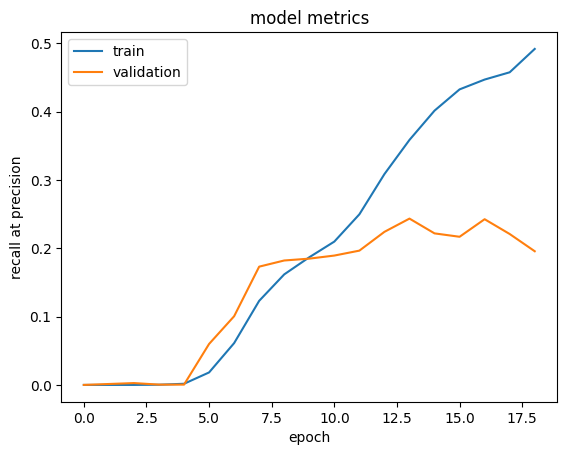

In [186]:
# input
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# conv + activation layers and pooling

conv1 = keras.layers.Conv1D(kernel_size=5, filters=20, strides=3, activation='relu')(embeddings)

pool1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)

convs = []
for ks in [3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=18, padding='same',strides=1)(pool1)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=15, padding='same',strides=2, kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
conv2 = keras.layers.concatenate(convs, axis=2)

pool2 = keras.layers.AveragePooling1D(pool_size=2)(conv2)

convs = []
for ks in [3,4,5,7,10]:
    conv1_ = keras.layers.Conv1D(kernel_size=ks, filters=12, padding='same',strides=3)(conv1)
    conv2_ = keras.layers.Conv1D(kernel_size=ks, filters=10, padding='same',strides=3, kernel_regularizer='l2', activation='relu')(conv1_)
    convs.append(conv2_)
conv2 = keras.layers.concatenate(convs, axis=2)

conv3 = keras.layers.Conv1D(kernel_size=3, filters=8, padding='same',strides=2)(conv2)

pool3 = keras.layers.AveragePooling1D(pool_size=2)(conv3)

conv4 = keras.layers.Conv1D(kernel_size=5, filters=7, padding='same',strides=2)(pool3)

pool4 = keras.layers.MaxPooling1D(pool_size=2)(conv4)

convs = []
for ks in [2,4,5,8]:
    conv1_ = keras.layers.Conv1D(kernel_size=ks, filters=5, padding='same',strides=1)(pool3)
    conv2_ = keras.layers.Conv1D(kernel_size=ks, filters=3, padding='same',strides=1, kernel_regularizer='l2', activation='relu')(conv1_)
    convs.append(conv2_)
conv4 = keras.layers.concatenate(convs, axis=2)

# fully connected (dense, dropout)

flatten = keras.layers.Flatten()(conv4)

dropout = keras.layers.Dropout(0.2)(flatten)

# outputs = keras.layers.Dense(len(label2id), activation='softmax')(dropout)

# output
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dropout)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')],
              )


# model.summary()

model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=50,
         callbacks=[checkpoint, early_stop])



print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Качество модели получилось низким, и чем больше слоев я добавляла, тем хуже она становилась, даже несмотря на то, что я меняла гиперпараметры много раз

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [ ]:
# не сделала :(